In [1]:
import json
import numpy as np
import struct
from tabulate import tabulate
import pymongo
from pymongo import MongoClient

import matplotlib.pyplot as plt
%matplotlib inline
from nltk.tokenize import word_tokenize

import numpy as np
import seaborn as sns
import pandas as pd
from gensim.models.word2vec import Word2Vec
from collections import Counter, defaultdict
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import StratifiedShuffleSplit

/home/olive/tfvenv/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [37]:
#connect to mongodb, start client session
client = MongoClient()
#connect to specific database
db = client.olive
#connect to specific collection
collection = db.yelp_reviews
#finding needs from full collection, data = collection.find({'restaurant_id':'neptune-oyster-boston'}) will find only neptune, etc.
data = collection.find({"restaurant_id":"neptune-oyster-boston"}) #finds all

#extract data from cursor
itembuffer=[]
for item in data:
     itembuffer.append(item)

#itembuffer has exactly the same structure as set_data, can directly plug in, regardless of find() or find({some criteria})



In [38]:
X,y = [],[]
#with open(filename,"r")as f:
set_data = itembuffer
for i in set_data:
    review = []
    for item in word_tokenize(i["review_detail"]):
        if item.isalpha(): # no need for stopword, clean not alpha, lower()
            review.append(item.lower())
    X.append(review)
    y.append(i["review_rating"])
X, y = np.array(X), np.array(y)
print("total examples %s" % len(y))   # training dataset with label"
print("y",y[:20])

total examples 3665
y ['5.0' '5.0' '5.0' '4.0' '5.0' '4.0' '5.0' '5.0' '5.0' '4.0' '4.0' '4.0'
 '5.0' '5.0' '5.0' '5.0' '5.0' '4.0' '5.0' '5.0']


In [39]:
GLOVE_6B_300D_PATH = "/home/olive/bbzy/glove.6B/glove.6B.300d.txt"
encoding = "utf-8"
glove_small = {}
#all_words = set()
#for item in X:
    #for words in item:
        #all_words.add(words)
#"set of tokenized word", only pick words in the train set
with open(GLOVE_6B_300D_PATH,"rb") as f:
    for line in f:
        parts = line.split()
        word = parts[0].decode(encoding)
        nums=np.array(parts[1:], dtype=np.float32)
        glove_small[word] = nums 

In [40]:
class MeanEmbeddingVectorizer(object):
    '''
     a word -> vector mapping and vectorizes texts by taking 
     the mean of all the vectors corresponding to individual 
     words
    '''
    def __init__(self, word2vec):
        self.word2vec = word2vec
        if len(word2vec)>0:
            self.dim=len(word2vec[next(iter(glove_small))])
        else:
            self.dim=0
            
    def fit(self, X, y):
        return self 

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec] 
                    or [np.zeros(self.dim)], axis=0)
            for words in X])

    
# and a tf-idf version of the same
class TfidfEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.word2weight = None
        if len(word2vec)>0:
            self.dim=len(word2vec[next(iter(glove_small))])
        else:
            self.dim=0
        
    def fit(self, X, y):
        tfidf = TfidfVectorizer(analyzer=lambda x: x)
        tfidf.fit(X)
        # if a word was never seen - it must be at least as infrequent
        # as any of the known words - so the default idf is the max of 
        # known idf's
        max_idf = max(tfidf.idf_)
        self.word2weight = defaultdict(
            lambda: max_idf, 
            [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])
    
        return self
    
    def transform(self, X):
        return np.array([
                np.mean([self.word2vec[w] * self.word2weight[w]
                         for w in words if w in self.word2vec] or
                        [np.zeros(self.dim)], axis=0)
                for words in X])       

In [41]:
etree_w2v = Pipeline([("glove vectorizer", MeanEmbeddingVectorizer(glove_small)), 
                        ("extra trees", ExtraTreesClassifier(n_estimators=200))])        
etree_w2v_tfidf = Pipeline([("glove vectorizer", TfidfEmbeddingVectorizer(glove_small)), 
                        ("extra trees", ExtraTreesClassifier(n_estimators=200))])  
mult_nb = Pipeline([("count_vectorizer", CountVectorizer(analyzer=lambda x: x)), ("multinomial nb", MultinomialNB())])
mult_nb_tfidf = Pipeline([("tfidf_vectorizer", TfidfVectorizer(analyzer=lambda x: x)), ("multinomial nb", MultinomialNB())])

all_models = [("w2v", etree_w2v),("w2v_tfidf", etree_w2v_tfidf),("mult_nb", mult_nb), ("mult_nb_tfidf", mult_nb_tfidf)]  

print("model done", type(etree_w2v),type(etree_w2v_tfidf),type(mult_nb),type(mult_nb_tfidf))    

model done <class 'sklearn.pipeline.Pipeline'> <class 'sklearn.pipeline.Pipeline'> <class 'sklearn.pipeline.Pipeline'> <class 'sklearn.pipeline.Pipeline'>


In [42]:

def benchmark(model, X, y,n):
    test_size = int(n*0.2)
    train_size = int(n*0.8-1)
    scores = []
    for train, test in StratifiedShuffleSplit(y, n_iter=5, test_size=test_size,train_size = train_size):
        X_train, X_test = X[train], X[test]
        y_train, y_test = y[train], y[test]
        scores.append(accuracy_score(model.fit(X_train, y_train).predict(X_test), y_test))
    return np.mean(scores)
train_sizes  = [100,500,1000,3665]#,1000,5000,10000,50000,510154
table = []
for name, model in all_models:
    for n in train_sizes:
    
        table.append({'model': name, 
                      'accuracy': benchmark(model, X, y,n),
                      "train_size":n})
        print("n_trainsize down")
df = pd.DataFrame(table)

n_trainsize down
n_trainsize down
n_trainsize down
n_trainsize down
n_trainsize down
n_trainsize down
n_trainsize down
n_trainsize down
n_trainsize down
n_trainsize down
n_trainsize down
n_trainsize down
n_trainsize down
n_trainsize down
n_trainsize down
n_trainsize down


In [43]:
df

,accuracy,model,train_size
0,0.590000,w2v,100
1,0.598000,w2v,500
2,0.605000,w2v,1000
3,0.607367,w2v,3665
4,0.660000,w2v_tfidf,100
5,0.602000,w2v_tfidf,500
6,0.605000,w2v_tfidf,1000
7,0.603820,w2v_tfidf,3665
8,0.610000,mult_nb,100
9,0.600000,mult_nb,500


In [19]:
#table2={}
#tabledata2=[]
#for item in table:
#    tabledata2.append({"model":item['model'],"accuracy":item['accuracy'],"train_size":n})
#df2 = pd.DataFrame(tabledata2)

[Text(0,0.5,'accuracy')]

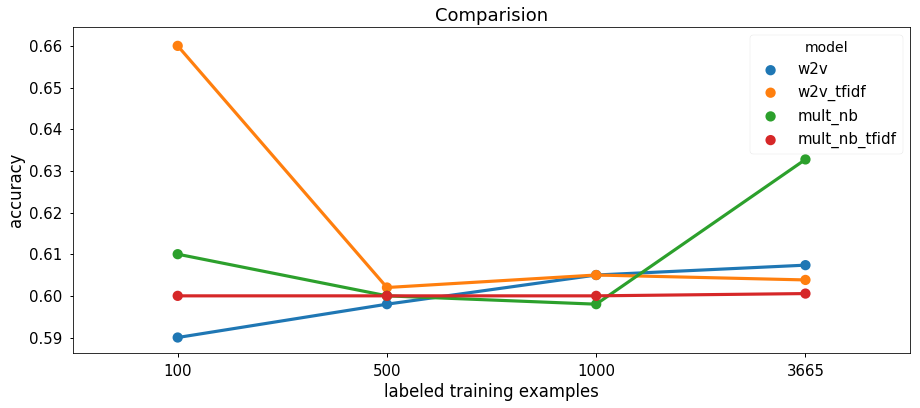

In [44]:
plt.figure(figsize=(15, 6))
fig = sns.pointplot(x='train_size', y='accuracy', hue='model', 
                    data=df[df.model.map(lambda x: x in ["w2v", "w2v_tfidf", "mult_nb", 
                                                         "mult_nb_tfidf"
                                                        ])])
sns.set_context("notebook", font_scale=1.5)
fig.set(ylabel="accuracy")
fig.set(xlabel="labeled training examples")
fig.set(title="Comparision")
fig.set(ylabel="accuracy")

In [47]:
df.to_json(path_or_buf = "/home/olive/qh_yelp/comparision_neptune.json",orient = "index")
